In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Generative_AI

/content/drive/MyDrive/Generative_AI


In [ ]:
!git config --global user.email "jdcastromi@gmail.com"
!git config --global user.name "jdiego-miyashiro"

In [ ]:
!git add . 
!git commit -m "first commit on this branch"

[colab_branch 3d86a5e] first commit on this branch
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 vqvae.h5


In [ ]:
!git push --set-upstream origin colab_branch

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!nvidia-smi

Tue May 16 22:19:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import pathlib
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU,Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import pathlib
import matplotlib.pyplot as plt

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
img_height = 128
img_width = 128
batch_size =18

### Creating tf.Datasets

In [ ]:

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)/255
  return img,

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [ ]:
list_ds = tf.data.Dataset.list_files('data_dir''*/*', shuffle=False)
val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.3)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        
        

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [ ]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

## Build the VQ-VAE

In [ ]:
embedding_dim = 32             # The number 
num_embeddings = 512

## Define Resnet Encoder

In [ ]:
def resnet_encoder(input_shape, num_filters, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # downsample via strided convolutions
    filters = [num_filters, num_filters*2] #, num_filters*4] #, num_filters*8]
    size = len(filters)
    for i in range(size):
        for j in range(2):
            # first block of each layer uses stride 2
            strides = 2 if j == 0 else 1
            x = resnet_block(x, filters[i], strides=strides)

    # final conv layer
    x = Conv2D(latent_dim, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.LayerNormalization()(x)

    model = Model(inputs, x,name='Encoder')
    return model


def resnet_block(inputs, filters, strides=1):
    x = BatchNormalization()(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)

    shortcut = inputs
    if strides != 1 or inputs.shape[3] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='valid')(inputs)

    x = Add()([x, shortcut])
    return x


In [ ]:
encoder_model = resnet_encoder(input_shape=(128, 128, 3), num_filters=64, latent_dim=embedding_dim)
encoder_model.summary()


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 64, 64, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_59 (BatchN  (None, 64, 64, 64)  256         ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Define Deconvolutional Generator (From DCGAN: https://arxiv.org/abs/1511.06434)

In [ ]:
encoder_output_shape = encoder_model.layers[-1].output_shape[1:]

In [ ]:
def tanh_plus_one(x):
    return tf.keras.activations.tanh(x) + 1.0

def dcgenerator(encoder_output_shape):
    # Input shape: (8, 8, 256)
    inputs = tf.keras.layers.Input(shape=encoder_output_shape)

    # Upsample to (16, 16, 128)
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (32, 32, 64)
    x = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)

    # Upsample to (64, 64, 32)
    x = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (128, 128, 16)
    x = tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (256, 256, 3)
    outputs = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation=tanh_plus_one, use_bias=True)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs,name='Decoder')

    return model


In [ ]:
decoder_model = dcgenerator(encoder_output_shape)

In [ ]:
decoder_model.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 16, 16, 32)]      0         
                                                                 
 conv2d_transpose_35 (Conv2D  (None, 32, 32, 512)      262144    
 Transpose)                                                      
                                                                 
 batch_normalization_113 (Ba  (None, 32, 32, 512)      2048      
 tchNormalization)                                               
                                                                 
 re_lu_21 (ReLU)             (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 64, 64, 256)      2097152   
 Transpose)                                                      
                                                           

## Define the VQVAE Architecture (Putting Resnet Encoder + Codebook + DC Decoder)

In [ ]:
def build_vqvae(num_embeddings=512,embedding_dim=32):
    vq_layer = VectorQuantizer(num_embeddings, embedding_dim, name="vector_quantizer")
    encoder = resnet_encoder(input_shape=(128, 128, 3), num_filters=64, latent_dim=embedding_dim)
    decoder = dcgenerator(encoder_output_shape)

    inputs = keras.Input(shape=(128, 128, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    vqvae_model = keras.Model(inputs, reconstructions, name="vq_vae")
    
    return vqvae_model

## Wrap the architecture in a tf.keras.models.Model class to define the custom training procedure

In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = build_vqvae(embedding_dim=self.latent_dim, num_embeddings=self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)


            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) 
            )
            total_loss = reconstruction_loss + 1*sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


### Training

In [ ]:
vqvae_trainer = VQVAETrainer(latent_dim=embedding_dim, num_embeddings=num_embeddings)

In [ ]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 Encoder (Functional)        (None, 16, 16, 32)        693536    
                                                                 
 vector_quantizer (VectorQua  (None, 16, 16, 32)       16384     
 ntizer)                                                         
                                                                 
 Decoder (Functional)        (None, 128, 128, 3)       2658179   
                                                                 
Total params: 3,368,099
Trainable params: 3,365,347
Non-trainable params: 2,752
_________________________________________________________________


In [ ]:
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(train_ds
                  ,epochs=100)


Epoch 1/100
169/169 [==============================] - 37s 143ms/step - loss: 1.2327 - reconstruction_loss: 0.0677 - vqvae_loss: 1.1179
Epoch 2/100
169/169 [==============================] - 23s 134ms/step - loss: 0.7667 - reconstruction_loss: 0.0361 - vqvae_loss: 0.7317
Epoch 3/100
169/169 [==============================] - 22s 131ms/step - loss: 0.4191 - reconstruction_loss: 0.0341 - vqvae_loss: 0.3853
Epoch 4/100
169/169 [==============================] - 22s 130ms/step - loss: 0.0838 - reconstruction_loss: 0.0338 - vqvae_loss: 0.0492
Epoch 5/100
169/169 [==============================] - 22s 132ms/step - loss: 0.0509 - reconstruction_loss: 0.0288 - vqvae_loss: 0.0210
Epoch 6/100
169/169 [==============================] - 22s 132ms/step - loss: 0.0435 - reconstruction_loss: 0.0273 - vqvae_loss: 0.0163
Epoch 7/100
169/169 [==============================] - 22s 130ms/step - loss: 0.0445 - reconstruction_loss: 0.0254 - vqvae_loss: 0.0185
Epoch 8/100
169/169 [===========================

In [ ]:
vqvae_trainer.save_weights('vqvae.h5')

In [ ]:
test = next(iter(val_ds))
train = next(iter(train_ds))

In [ ]:
out = vqvae_trainer.vqvae(train)

In [ ]:
out

<tf.Tensor: shape=(18, 128, 128, 3), dtype=float32, numpy=
array([[[[0.59426606, 0.6472752 , 0.6921537 ],
         [0.59708923, 0.64981824, 0.6945948 ],
         [0.69528115, 0.7067706 , 0.7152995 ],
         ...,
         [0.5448595 , 0.5821277 , 0.61231476],
         [0.5398019 , 0.5675554 , 0.5781868 ],
         [0.5451376 , 0.5718399 , 0.5820335 ]],

        [[0.6017377 , 0.6555978 , 0.70176995],
         [0.6051888 , 0.6594887 , 0.7047979 ],
         [0.6924689 , 0.7040689 , 0.7124922 ],
         ...,
         [0.5399257 , 0.5787288 , 0.60643303],
         [0.53390515, 0.562464  , 0.5727689 ],
         [0.5392883 , 0.5659214 , 0.577106  ]],

        [[0.6011684 , 0.6369285 , 0.6694552 ],
         [0.6041763 , 0.640009  , 0.6735842 ],
         [0.6620033 , 0.67554855, 0.7024076 ],
         ...,
         [0.51743543, 0.5596405 , 0.6162745 ],
         [0.5079918 , 0.5603508 , 0.6038734 ],
         [0.51572007, 0.5665937 , 0.60932237]],

        ...,

        [[0.41821516, 0.45750326,

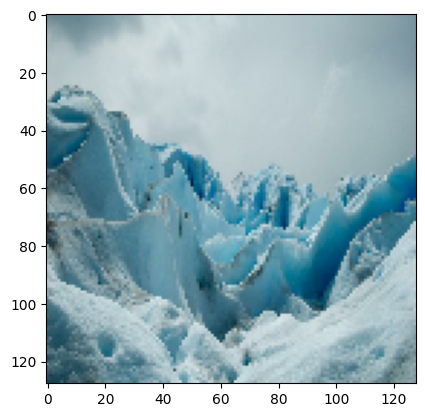

In [ ]:
plt.imshow(train[0][0])

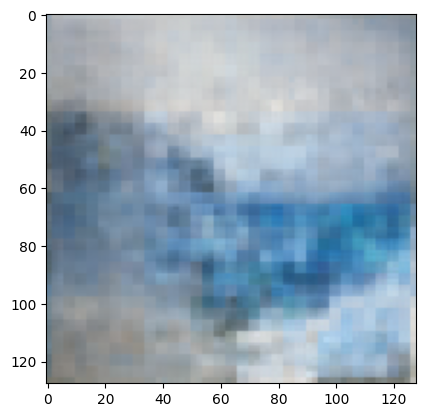

In [ ]:
plt.imshow(out[0])